# Steam project 👾

But:
Analyser un large jeu de données pour comprendre les facteurs qui influencent la popularité d'un jeu vidéo.

### ⬇️ Import librairies & création session Spark

In [0]:
from pyspark.sql.types import StructType, StructField, ArrayType,IntegerType, DataType
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from copy import copy
from typing import List, Dict, Generator, Union, Callable
from functools import reduce
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf,split, col, explode, count, row_number, substring, sum
from pyspark.sql.window import Window

In [0]:
spark = SparkSession.builder.getOrCreate()
filepath = "s3://full-stack-bigdata-datasets/Big_Data/Project_Steam/steam_game_output.json"
df = spark.read.format('json').load(filepath, multiline=True)

## 🧼Nettoyage et explode

In [0]:
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, DataType, ArrayType
from copy import copy
from functools import reduce

def clean_and_explode_dataframe(df):
    def sanitize_field_name(s: str) -> str:
        return s.replace("&", "And").replace("-", "_").replace("\"", "_")\
            .replace("[", "_").replace("]", "_").replace(".", "_")\
            .replace(" ", "_").replace("'", "")

    def sanitize_field(field: StructField) -> StructField:
        field = copy(field)
        field.name = sanitize_field_name(field.name)
        field.dataType = clean_schema(field.dataType)
        return field

    def clean_schema(dataType: DataType) -> DataType:
        dataType = copy(dataType)
        if isinstance(dataType, StructType):
            dataType.fields = [sanitize_field(f) for f in dataType.fields]
        elif isinstance(dataType, ArrayType):
            dataType.elementType = clean_schema(dataType.elementType)
        return dataType

    def sanitize_column_name(col_name):
        return '_'.join(col_name.split(".")[1:])

    def flatten_schema(schema, prefix=None):
        fields = []
        for field in schema.fields:
            name = f"{prefix}.{field.name}" if prefix else field.name
            dataType = field.dataType
            if isinstance(dataType, ArrayType):
                dataType = dataType.elementType
            if isinstance(dataType, StructType):
                fields.extend(flatten_schema(dataType, prefix=name))
            else:
                fields.append(name)
        return fields

    cleaned_df = spark.createDataFrame(df.rdd, clean_schema(df.schema))
    flattened_columns = flatten_schema(cleaned_df.schema)
    exploded_df = reduce(lambda memo_df, col_name: memo_df.withColumn(col_name, col(col_name)), flattened_columns, cleaned_df).drop('data', 'id')
    renamed_df = reduce(lambda memo_df, col_name: memo_df.withColumnRenamed(col_name, sanitize_column_name(col_name)), exploded_df.columns, exploded_df)

    return renamed_df
#df nettoyer et exploded
df = clean_and_explode_dataframe(df)


## 💵Prix sous format float et integer

In [0]:
def convert_columns_data_type(df: DataFrame) -> DataFrame:
    df = df.withColumn("price", col("price").cast("float"))
    df = df.withColumn("initialprice", col("initialprice").cast("float"))
    df = df.withColumn("discount", col("discount").cast("integer"))
    return df

df = convert_columns_data_type(df)

## 🤔 Questionnement et recherches 📈 🎮

* Quel éditeur a sorti le plus de jeux sur Steam (Top 3)?

In [0]:
df.createOrReplaceTempView('VideoGame_table')
top_publishers = spark.sql("""
          SELECT publisher, COUNT(publisher) AS cnt
          FROM VideoGame_table
          GROUP BY publisher
          ORDER BY cnt DESC
          LIMIT 3
""")
display(top_publishers)

publisher,cnt
Big Fish Games,422
8floor,202
SEGA,165


Big Fish Games est le premier du top 3 des éditeurs ayant publié le plus de jeux dans cette dataframe avec 422 jeux, suivit de 8 floor et SEGA.

* Quels sont les jeux les mieux notés ?

In [0]:
top_games = spark.sql("""
          SELECT appid, name, positive
          FROM VideoGame_table
          ORDER BY positive DESC
          LIMIT 3
""")
display(top_games)

appid,name,positive
730,Counter-Strike: Global Offensive,5943345
570,Dota 2,1534895
271590,Grand Theft Auto V,1229265


* Publications au cours des années ?

In [0]:
year_count = df.select(F.substring('release_date',1,4).alias('year')).groupBy('year').count().orderBy('year')
year_count_pd = year_count.toPandas()
fig = px.line(year_count_pd, x='year', y='count', title='Number of Games Released per Year')
fig.show()

Depuis 2013, on voit qu'il y'a une tendance a la hausse en terme de publication de jeux sur la platforme steam. \
Un premier pic est connu en 2018,puis un autre en 2020-2021.

* Combien de jeux sont en réductions ?

In [0]:
df_price = df.select(['initialprice', 'discount', 'price'])
nb_discount = df_price.filter(df_price['discount'] > 0).count()
print("Il y'a :"+str(nb_discount))

Il y'a :2518


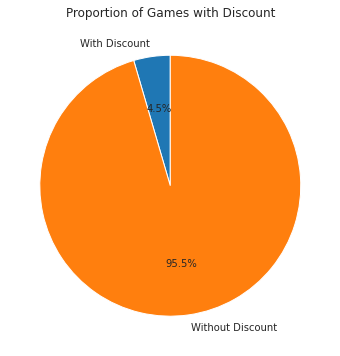

In [0]:
proportion = nb_discount / df_price.count() * 100
labels = ['With Discount', 'Without Discount']
sizes = [proportion, 100 - proportion]
plt.figure(figsize=(6, 6))
sns.set_style("whitegrid")
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Games with Discount')
plt.show()

Un peu plus de 4% des jeux sont en promo (2518)

* Distribution des langues ?

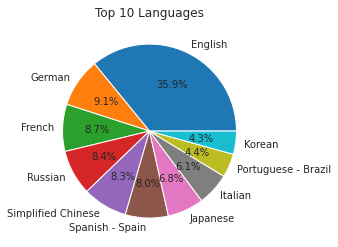

In [0]:
df_expanded_languages = df.select(explode(split('languages', ', ')).alias('language'))
language_frequency = df_expanded_languages.groupBy('language').count()
top_languages = language_frequency.orderBy('count', ascending=False).limit(10)
top_languages_pd = top_languages.toPandas()
plt.pie(top_languages_pd['count'], labels=top_languages_pd['language'], autopct='%1.1f%%')
plt.title('Top 10 Languages')
plt.show()


36% des jeux sont en anglais, 9% en allemand, 8.7% en francais.

* Distribution des genres ?

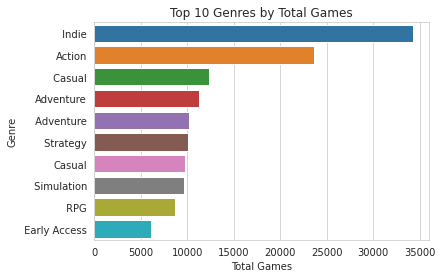

In [0]:
top_genres = spark.sql("""
          SELECT genre_exploded AS genre, COUNT(name) AS total_games
          FROM (
            SELECT name, explode(split(genre, ',')) AS genre_exploded
            FROM VideoGame_table
          )
          GROUP BY genre_exploded
          ORDER BY total_games DESC
          LIMIT 10
""")
top_genres_pd = top_genres.toPandas()
sns.barplot(x='total_games', y='genre', data=top_genres_pd)
plt.xlabel('Total Games')
plt.ylabel('Genre')
plt.title('Top 10 Genres by Total Games')
plt.show()


Le top 3 des jeux sont catégoriser comme jeux Indie (indépendant), Action, ou/et casual.

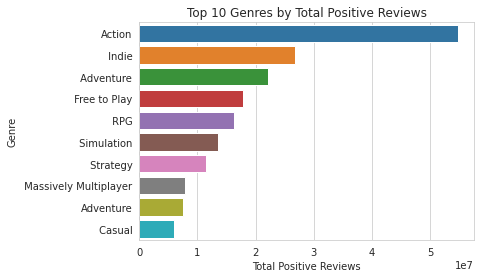

In [0]:
top_genres = spark.sql("""
          SELECT genre_exploded AS genre, SUM(positive) AS total_positive
          FROM (
            SELECT name, positive, explode(split(genre, ',')) AS genre_exploded
            FROM VideoGame_table
          )
          GROUP BY genre_exploded
          ORDER BY total_positive DESC
          LIMIT 10
""")
top_genres_pd = top_genres.toPandas()
sns.barplot(x='total_positive', y='genre', data=top_genres_pd)
plt.xlabel('Total Positive Reviews')
plt.ylabel('Genre')
plt.title('Top 10 Genres by Total Positive Reviews')
plt.show()

Les jeux qui ont le plus d'avis positifs sont en majorité des jeux d'Action, Indie et des jeux d'aventure pour la plus part.

* Evolution des 3 meilleurs genres par an, au cours des années :

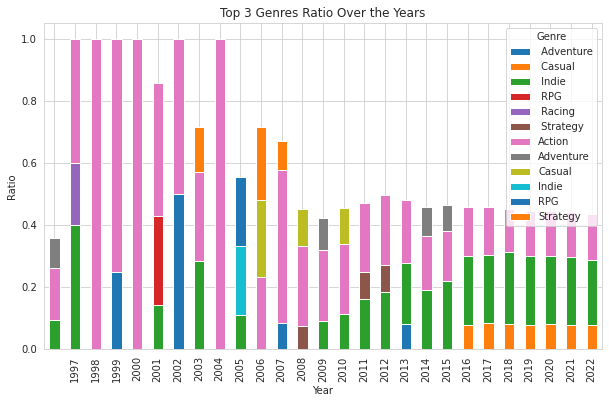

In [0]:
selected_columns = ['name', 'publisher', 'genre', 'positive', 'negative', 'initialprice', 'discount', 'price', 'owners', 'release_date']
df_genre_initial = df.select(selected_columns)

# Extract the year
df_genre_initial = df_genre_initial.withColumn('year', substring('release_date', 1, 4))
df_genre_list = df_genre_initial.withColumn("genre", split(col("genre"), ","))
gender = df_genre_list.withColumn('genre_exploded', explode(df_genre_list.genre))
genre_counts = gender.groupBy('year', 'genre_exploded').agg(count('name').alias('total_games'))
year_totals = genre_counts.groupBy('year').agg(sum('total_games').alias('total_year_games'))
genre_counts_with_totals = genre_counts.join(year_totals, on='year')
genre_counts_with_totals = genre_counts_with_totals.withColumn('ratio', col('total_games') / col('total_year_games'))
window_spec = Window.partitionBy('year').orderBy(col('total_games').desc())
genre_counts_ranked = genre_counts_with_totals.withColumn('rank', row_number().over(window_spec))
top_genres = genre_counts_ranked.filter(col('rank') <= 3)
top_genres_pd = top_genres.toPandas()
top_genres_pivot = top_genres_pd.pivot(index='year', columns='genre_exploded', values='ratio')
top_genres_pivot.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.title('Top 3 Genres Ratio Over the Years')
plt.legend(title='Genre')
plt.show()

* Quels sont les genres les plus lucratifs ?

In [0]:
#df_genre.createGlobalTempView('genre_table')

In [0]:
gender.select('owners').distinct().count()

Out[36]: 13

In [0]:
gender.select('owners').distinct().sort('owners', ascending=False).show(13,truncate=False)

+--------------------------+
|owners                    |
+--------------------------+
|500,000 .. 1,000,000      |
|50,000,000 .. 100,000,000 |
|50,000 .. 100,000         |
|5,000,000 .. 10,000,000   |
|200,000,000 .. 500,000,000|
|200,000 .. 500,000        |
|20,000,000 .. 50,000,000  |
|20,000 .. 50,000          |
|2,000,000 .. 5,000,000    |
|100,000 .. 200,000        |
|10,000,000 .. 20,000,000  |
|1,000,000 .. 2,000,000    |
|0 .. 20,000               |
+--------------------------+



In [0]:
def extractMinOwners(str):
    result = str.split(" .. ")
    return int(''.join(result[0].split(",")))

def extractMaxOwners(str):
    result = str.split(" .. ")
    return int(''.join(result[1].split(",")))

to_int_udf_min = udf(extractMinOwners, IntegerType())
to_int_udf_max = udf(extractMaxOwners, IntegerType())

df_genre_revenue = gender.withColumn('min_owners', to_int_udf_min(col('owners')))
df_genre_revenue = df_genre_revenue.withColumn('max_owners', to_int_udf_max(col('owners')))
df_genre_revenue = df_genre_revenue.withColumn('min_revenue', col('min_owners') * col('price').cast('float'))
df_genre_revenue = df_genre_revenue.withColumn('max_revenue', col('max_owners') * col('price').cast('float'))
genre_revenue = df_genre_revenue.groupBy('genre_exploded').agg(sum('min_revenue').alias('total_min_revenue'), sum('max_revenue').alias('total_max_revenue'))
genre_revenue = genre_revenue.withColumn('total_min_revenue', col('total_min_revenue') / 100)
genre_revenue = genre_revenue.withColumn('total_max_revenue', col('total_max_revenue') / 100)
genre_revenue = genre_revenue.orderBy(col('total_min_revenue').desc(), col('total_max_revenue').desc())
genre_revenue.show(30, truncate=False)


+----------------------+-----------------+-----------------+
|genre_exploded        |total_min_revenue|total_max_revenue|
+----------------------+-----------------+-----------------+
|Action                |3.591628817984E10|8.154338349472E10|
| Adventure            |1.727254939648E10|3.90791055904E10 |
| Indie                |1.563996086704E10|3.724732040208E10|
| RPG                  |1.358131011936E10|3.10963508968E10 |
| Strategy             |9.61120923184E9  |2.201849845824E10|
| Simulation           |8.92224467488E9  |2.037027442528E10|
|Adventure             |5.34635735984E9  |1.279346511264E10|
| Massively Multiplayer|3.62995626368E9  |8.0157275792E9   |
|Indie                 |3.49475633072E9  |8.31111703328E9  |
| Early Access         |3.14101020064E9  |7.75004631856E9  |
|RPG                   |3.093818344E9    |6.5748073928E9   |
| Casual               |2.98792882352E9  |7.55145594736E9  |
|Strategy              |2.75118302512E9  |5.91919184704E9  |
|Simulation            |

11. La plupart des jeux sont-ils plutôt disponibles sur Windows/Mac/Linux ?

In [0]:
selected_columns = ['name', 'platforms_linux', 'platforms_mac', 'platforms_windows']
df_platform = df.select(selected_columns)
linux = df_platform.select('platforms_linux').where(df_platform['platforms_linux'] == True).count()
mac = df_platform.select('platforms_mac').where(df_platform['platforms_mac'] == True).count()
windows = df_platform.select('platforms_windows').where(df_platform['platforms_windows'] == True).count()
total_games = df_platform.count()

# ratio par platform
linux_ratio = linux / total_games
mac_ratio = mac / total_games
windows_ratio = windows / total_games

print(f'linux: {linux} ({linux_ratio:.2%}), mac: {mac} ({mac_ratio:.2%}), windows: {windows} ({windows_ratio:.2%})')


linux: 8458 (15.19%), mac: 12770 (22.93%), windows: 55676 (99.97%)


 Quelles sont les caractéristiques des jeux les plus joués ?

In [0]:
df_genre_list.createOrReplaceTempView('price_and_owners_table')

In [0]:
spark.sql("""
          SELECT owners, COUNT(owners) AS owners_group, AVG(price) / 100 AS avg_price
          FROM price_and_owners_table
          GROUP BY owners
          ORDER BY owners_group DESC
""").show()

+--------------------+------------+------------------+
|              owners|owners_group|         avg_price|
+--------------------+------------+------------------+
|         0 .. 20,000|       38072| 7.097593507039294|
|    20,000 .. 50,000|        7285| 7.300844200411805|
|   50,000 .. 100,000|        3695| 8.340476319350474|
|  100,000 .. 200,000|        2519| 9.329039301310043|
|  200,000 .. 500,000|        2162|10.661660499537465|
|500,000 .. 1,000,000|         933|13.926548767416934|
|1,000,000 .. 2,00...|         526|15.781977186311787|
|2,000,000 .. 5,00...|         335|18.133731343283582|
|5,000,000 .. 10,0...|          97|18.260618556701033|
|10,000,000 .. 20,...|          41|12.091463414634147|
|20,000,000 .. 50,...|          21|10.422857142857142|
|50,000,000 .. 100...|           4|            4.9975|
|200,000,000 .. 50...|           1|               0.0|
+--------------------+------------+------------------+



Il semble qu'il y ait un marché important pour les jeux gratuits, car un jeu a accumulé plus de 200 millions de téléchargements sans aucun coût. Cependant, les jeux vendus à 4,99$ ont également connu un certain succès, avec quatre jeux atteignant plus de 50 millions de téléchargements. En revanche, les jeux vendus à 10$ ont un nombre de téléchargements plus faible, avec seulement 21 jeux atteignant plus de 20 millions de téléchargements.

De plus, la plupart des jeux ont été téléchargés moins de 20 000 fois et sont vendus à 7$. Cela suggère qu'il y a un marché pour les jeux gratuits et modérément payants, mais que les jeux vendus à des prix significativement plus élevés peuvent ne pas performer aussi bien en termes de téléchargements.

Par conséquent, si l'objectif est de maximiser le nombre de téléchargements, il peut être intéressant de fixer le prix des jeux à 4,99$ ou moins. Cependant, il est important de prendre en compte d'autres facteurs tels que les coûts de développement, les marges bénéficiaires et la valeur et la qualité globale du jeu lors de la fixation du prix.

## Conclusion

Les jeux qui connaissent le plus de succès sont principalement disponibles sur les plateformes Windows et Mac. Les genres les plus populaires sont l'Indie, l'Action, le Casual et l'Aventure. La fourchette de prix moyenne des jeux est comprise entre 0 et 10 dollars, et pour vendre plus de jeux, il est préférable de proposer un prix entre 0 et 4,99 dollars. Il est également essentiel d'avoir une version anglaise du jeu et de le classer comme tout public, sans restriction d'âge.

